## Set CUDA visbility and number of devices

In [1]:
!unset CUDA_VISIBLE_DEVICES

In [2]:
import os
device_id="0"  # for single device
# device_id="0,1,2,3,4,5,6,7"   # for multiple devices
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"    # map to PCI BUS ID so that order of GPUs remain consistent.
os.environ["CUDA_VISIBLE_DEVICES"]=device_id

## Import packages

In [3]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch, os, time, random
import torch.nn.functional as F

# from skimage import transform
from itertools import product
from torch.utils.data import Dataset
from IPython.display import clear_output, display
from collections import namedtuple, OrderedDict
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torchvision import models

torch.set_grad_enabled(True)
torch.set_printoptions(linewidth=120)
pd.set_option('display.max_rows', 120)
# from torch.utils.tensorboard import SummaryWriter
torch.backends.cudnn.benchmark = True

In [4]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.device_count()

1

## Import Dataset (CIFAR10) and DataLoader

In [5]:
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1), transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

trainset = torchvision.datasets.CIFAR10(root='~/datasets/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='~/datasets/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## View some example images from the dataset

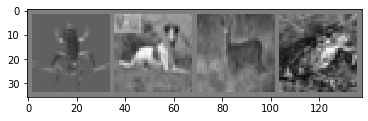

 frog   dog  deer  frog


In [6]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray', vmin=0, vmax=255)
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Import network (resnet50) and redefine its last layer for 10 classes

In [7]:
def get_network():
    network = torchvision.models.resnet50(pretrained=False)
    network.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    network.fc = nn.Linear(2048, out_features=10) # use 512 for resnet 18, 34 and 2048 for resnet50, 101 and 152
    return network
print(get_network())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Define Run Builder

In [8]:
class RunBuilder():
    @staticmethod
    def get_runs(params):
        
        Run = namedtuple('Run', params.keys())
        
        runs = []
        for v in product(*params.values()):
            runs.append(Run(*v))
            
        return runs

## Define Run Manager

In [9]:
class RunManager():
    def __init__(self):
        
        self.epoch_count = 0
        self.epoch_loss = 0
        self.epoch_test_loss = 0         #####  test
        self.epoch_num_test_correct = 0  #####  test
        
        self.epoch_num_correct = 0
        self.epoch_start_time = None
        
        self.run_params = None
        self.run_count = 0 
        self.run_data = []
        self.run_start_time = None
        
        
        self.network = None
        self.loader = None
        self.test_loader = None ##### test
        self.tb = None
        
        
    def begin_run(self, run, network, loader, test_loader):
        
        self.run_start_time = time.time()
        
        self.run_params = run
        
#         self.run_count += 1
        
        self.network = network
        self.loader = loader
        self.test_loader = test_loader     ##### test
        
#---------------------------- tensorboard specific ------------------------------#
#         self.tb = SummaryWriter(comment=f'-{run}')
        
#         images, labels = next(iter(self.loader))
# #         grid = torchvision.utils.make_grid(images)
        
# #         self.tb.add_image('images', grid)
#         self.tb.add_graph(self.network, images)
##################################################################################        

    def end_run(self):
        
#---------------------------- tensorboard specific ------------------------------#        
#         self.tb.close()
##################################################################################
        self.epoch_count = 0
        
    def begin_epoch(self):
        self.epoch_start_time = time.time()
        
#         self.epoch_count += 1
        self.epoch_loss = 0
        self.epoch_test_loss = 0               ###### test
        self.epoch_num_correct = 0
        self.epoch_num_test_correct = 0        ###### test
        
    def end_epoch(self, run_index, epoch, fileName):
        self.epoch_count = epoch + 1
        self.run_count = run_index + 1
        
        epoch_duration = time.time() - self.epoch_start_time
        run_duration = time.time() - self.run_start_time
        
        loss = self.epoch_loss / len(self.loader.dataset)
        accuracy = self.epoch_num_correct / len(self.loader.dataset)
    
#------------------------------ test set metrics ------------------------------#    
        test_loss = self.epoch_test_loss / len(self.test_loader.dataset)

        test_accuracy = self.epoch_num_test_correct / len(self.test_loader.dataset)
################################################################################        
        
        
#--------------------------- tensorboard specific -------------------------------#        
#         self.tb.add_scalar('Loss', loss, self.epoch_count)
#         self.tb.add_scalar('Accuracy', accuracy, self.epoch_count)
        
#         for name, param in self.network.named_parameters():
#             self.tb.add_histogram(name, param, self.epoch_count)
#             self.tb.add_histogram(f'{name}.grad', param.grad, self.epoch_count)
##################################################################################
            
        results = OrderedDict()
        results['run'] = self.run_count
        results['epoch'] = self.epoch_count
        results['train loss'] = loss
        results['test loss'] = test_loss
        results['train accuracy'] = accuracy
        results['test accuracy'] = test_accuracy
        results['epoch duration'] = epoch_duration
        results['run duration'] = run_duration
        for k, v in self.run_params._asdict().items():
            results[k] = v
        self.run_data.append(results)
        df = pd.DataFrame.from_dict(self.run_data, orient='columns')
        header = (True if results['run']+results['epoch']==2 else False)
        pd.DataFrame.from_dict([results], orient='columns').to_csv(f'{fileName}.csv', mode='a', index=False, header=header)
        
        # jupyter notebook specific 
        clear_output(wait=True)
        display(df)
        
    def track_loss(self, loss):
        self.epoch_loss += loss.item() * self.loader.batch_size        
        
    def track_num_correct(self, preds, labels):
        self.epoch_num_correct += self._get_num_correct(preds, labels)
        
#----------------------------- test set metrics -------------------------------------#
    def track_test_loss(self, loss):
        self.epoch_test_loss += loss.item() * self.test_loader.batch_size
        
    def track_num_test_correct(self, preds, labels):
        self.epoch_num_test_correct += self._get_num_correct(preds, labels)
######################################################################################    
    
    @torch.no_grad()
    def _get_num_correct(self, preds, labels):
        return preds.argmax(dim=1).eq(labels).sum().item()
    
    
    def save(self, fileName):
        
        pd.DataFrame.from_dict(
            self.run_data,
            orient='columns'
        ).to_csv(f'{fileName}.csv', index=False)
        
#         with open(f'{fileName}.json', 'w', encoding='utf-8') as f:
#             json.dump(self.run_data, f, ensure_ascii=False, indent=4)
        

## Define hyperparameters 
- You can define your own hyperparameter values to be tested in a list but you will have to replace it in code with <code>run.<i>hyperparameter</i></code> name in the code below.

In [10]:
params = OrderedDict(lr=[0.001, 0.01, 0.1],
                     momentum=[0.05, 0.9, 0.99],
                     weight_decay=[0.5e-2, 1e-2, 1.2e-2, 1.3e-2, 1.35e-2],
                     batch_size=[64, 128, 256],
                     pin_memory=[True],
                     transform=[True, False],
                     shuffle=[True, False],
                     num_workers=[2]
                    )

## Define Transforms

In [11]:
transform = {'train':transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
]),
            'test':transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])}

## Train Test loop

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

runs = RunBuilder.get_runs(params)
start_run = 0
start_epoch = 0
epochs = 10   # Set epochs to run
network_instance = True
if os.path.exists('resnet50.pth'):
    with open('resnet50.pth', 'rb') as f:
        checkpoint = torch.load(f)
        network_instance = False
        network = get_network()
        if torch.cuda.device_count() > 1:
            network = nn.DataParallel(network)
            network.module.load_state_dict(checkpoint['model_state_dict'])
        else:
            network.load_state_dict(checkpoint['model_state_dict'])
    
        network.to(device)
        start_run = checkpoint['run']
        start_epoch = checkpoint['epoch']
        if start_epoch+1 == epochs and start_run != len(runs)-1:
            start_epoch = 0
            start_run = start_run + 1
        else:
            start_epoch = start_epoch + 1
        run = runs[start_run]
        optimizer = optim.AdamW(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        loss = checkpoint['loss']

best_loss = 999
m = RunManager()
for run_index in range(start_run, len(runs)):
    run = runs[run_index]
    train_set = torchvision.datasets.CIFAR10(root='~/datasets/', train=True,
                                             download=True, transform=(transform['train'] if run.transform else None))

    test_set = torchvision.datasets.CIFAR10(root='~/datasets/', train=False,
                                            download=True, transform=(transform['test'] if run.transform else None))

    if network_instance == True:
        network = get_network()
        if torch.cuda.device_count() > 1:
#             print("Let's use", torch.cuda.device_count(), "GPUs!")
            network = nn.DataParallel(network)
            optimizer = optim.AdamW(network.module.parameters(), lr=run.lr, weight_decay=run.weight_decay)
        else:
            optimizer = optim.AdamW(network.parameters(), lr=run.lr, weight_decay=run.weight_decay)
        network.to(device)
    network_instance = True
    
    loader = torch.utils.data.DataLoader(train_set, batch_size=run.batch_size, num_workers=run.num_workers,
                                         shuffle=run.shuffle, pin_memory=run.pin_memory)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=run.batch_size, num_workers=run.num_workers,
                                              pin_memory=run.pin_memory)
        

    m.begin_run(run, network, loader, test_loader)
    for epoch in range(start_epoch, epochs):
        m.begin_epoch()
        for batch in loader:
            images = batch[0].to(device)
            labels = batch[1].to(device)
            network.train()
            preds = network(images)  # Pass batch
            loss = F.cross_entropy(preds, labels) # Calculate loss
            optimizer.zero_grad() # Zero gradients
            loss.backward() # Calculate gradients
            optimizer.step() # Update weights
            
            m.track_loss(loss)
            m.track_num_correct(preds, labels)
        del loss, preds    # memory managemnt   
        with torch.no_grad():
            for batch in test_loader:
                network.eval()
                images = batch[0].to(device)
                labels = batch[1].to(device)
                preds = network(images)  # Pass batch
                loss = F.cross_entropy(preds, labels) # Calculate loss
                m.track_test_loss(loss)
                m.track_num_test_correct(preds, labels)
        if torch.cuda.device_count() > 1:
            state_dict = network.module.state_dict()
        else:
            state_dict = network.state_dict()
        checkpoint = {'run': run_index, 'epoch': epoch, 'loss': loss, 'model_state_dict': state_dict,
                      'optimizer_state_dict': optimizer.state_dict()}
        if loss < best_loss:
            torch.save(checkpoint, 'best_model.pth')
            best_loss = loss
        torch.save(checkpoint, 'resnet50.pth')
        m.end_epoch(run_index, epoch, 'resnet50')
    start_epoch = 0
    m.end_run()

,run,epoch,train loss,test loss,train accuracy,test accuracy,epoch duration,run duration,lr,momentum,weight_decay,batch_size,pin_memory,transform,shuffle,num_workers
0,1,1,1.966833,1.945494,0.33186,0.4256,46.669232,46.669244,0.001,0.05,0.005,64,True,True,True,2
1,1,2,1.953455,11.180953,0.34156,0.2864,43.141361,89.835330,0.001,0.05,0.005,64,True,True,True,2
2,1,3,1.982019,68.715367,0.30170,0.2123,44.039442,134.027552,0.001,0.05,0.005,64,True,True,True,2
3,1,4,1.789293,1.698434,0.36206,0.4084,44.640619,178.688910,0.001,0.05,0.005,64,True,True,True,2
4,1,5,1.595825,2.156107,0.42938,0.4408,44.909900,223.617544,0.001,0.05,0.005,64,True,True,True,2
5,1,6,1.642494,1.711458,0.42382,0.4261,43.101152,266.736770,0.001,0.05,0.005,64,True,True,True,2
6,1,7,1.759728,1.644482,0.37602,0.4469,44.352245,311.109594,0.001,0.05,0.005,64,True,True,True,2
7,1,8,1.556691,1.684423,0.45186,0.4961,41.957130,353.087648,0.001,0.05,0.005,64,True,True,True,2


KeyboardInterrupt: 